In [211]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from neuromaps.images import load_data, load_gifti, annot_to_gifti, relabel_gifti
from neuromaps.datasets import fetch_annotation
from neuromaps.resampling import resample_images
from neuromaps.nulls import alexander_bloch, burt2020
from neuromaps.parcellate import Parcellater
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
from neuromaps import transforms 
from neuromaps.stats import compare_images
from neuromaps.nulls import hungarian
from statsmodels.stats.multitest import multipletests
import matplotlib.lines as mlines
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [14]:

# define paths
path = '/Users/laurituominen/Documents/Research/Reettis/neuromaps/'

# load in parcellation file
dk_fsaverage_10k = (path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-10k_hemi-L.label.gii.gz',
                     path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-10k_hemi-R.label.gii.gz')
dk_fsaverage_164k = (path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-164k_hemi-L.aparc-1.annot',
                     path + 'parcellations/atlas-desikankilliany_space-fsaverage_den-164k_hemi-R.aparc-1.annot')
dk_mni = path + 'parcellations/atlas-desikankilliany_space-MNI_res-1mm.nii.gz'

# make sure label IDs are consecutive across hemispheres
dk_fsaverage_10k = relabel_gifti(dk_fsaverage_10k)
dk_fsaverage_164k = annot_to_gifti(dk_fsaverage_164k)  # this does relabel_gift and also converts the annot file to gifti

# make the parcellaters
parcellater_fs10k = Parcellater(dk_fsaverage_10k, 'fsaverage')
parcellater_fs164k = Parcellater(dk_fsaverage_164k, 'fsaverage')
parcellater_mni = Parcellater(dk_mni, 'MNI152')

parcellaters = {"MNI152" : parcellater_mni, "fsaverage_164k": parcellater_fs164k, "fsaverage_10k": parcellater_fs10k}

In [15]:
# download enigma
enigmamap = pd.read_csv(path+'data/ENIGMA_S32_partial_correlation_between_cortical_thickness_and_chlorpromazine_equivalents.csv')
enigmamap.drop([68, 69], inplace=True)  # remove the last two rows
enigma_parc = enigmamap['partial_r'].to_numpy()

# download the regions for MNI152 
rois = pd.read_csv(path+'parcellations/atlas-desikankilliany.csv')
rois = rois[(rois['structure'] == 'cortex')].id.to_numpy()


In [16]:
# get sig-maps 

img_L = load_data(path + 'data/lh.sig.nii')
img_gii_L = construct_shape_gii(img_L)

img_R = load_data(path + 'data/rh.sig.nii')  
img_gii_R = construct_shape_gii(img_R)

#turku_parc
turku_map = (img_gii_L, img_gii_R)

turku_parc = parcellater_fs164k.fit_transform(turku_map, space='fsaverage', ignore_background_data=True)

In [17]:
# get annotations 
annotations = list(fetch_annotation(source=['hcps1200',
                                            'margulies2016',
                                            'raichle',
                                            'ding2010', 
                                            'finnema2016', 
                                            'dubois2015',
                                            'dukart2018',
                                            'gallezot2010',
                                            'gallezot2017',
                                            'hillmer2016',
                                            'jaworska2020',
                                            'kaller2017',
                                            'kantonen2020',
                                            'laurikainen2018',
                                            'normandin2015',
                                            'radnakrishnan2018',
                                            'sandiego2015',
                                            'satterthwaite2014',
                                            'sasaki2012',
                                            'savli2012',
                                            'satterthwaite2014',
                                            'smith2017',
                                            'tuominen',
                                            'neurosynth',
                                            'mueller2013',
                                            'naganawa2020',
                                            'fazio2016']).keys())

annotations.extend(fetch_annotation(source=['norgaard2021', 'beliveau2017'], space='fsaverage').keys())


In [18]:
# prepare data 
parcellated = dict([])
for (src, desc, space, den) in annotations:

    annot = fetch_annotation(source=src, desc=desc, space=space, den=den)
    
    if space == 'MNI152':
        parcellater = parcellater_mni
    elif space == 'fsaverage' and den == '164k':
        parcellater = parcellater_fs164k
    elif space == 'fsLR' and den == '164k':
        space = 'fsaverage'
        annot = transforms.fslr_to_fsaverage(annot, target_density='164k')
        parcellater = parcellater_fs164k
    elif space == 'fsLR' and den != '164k':
        # unfortunately for fsLR-4k we are upsampling to fsaverage-10k to parcellate but it should be fine
        space = 'fsaverage'
        annot = transforms.fslr_to_fsaverage(annot, target_density='10k')
        parcellater = parcellater_fs10k

    parcellated[desc] = parcellater.fit_transform(annot, space=space, ignore_background_data=True)
    
    if parcellated[desc].shape == (1,83):
        parcellated[desc] = parcellated[desc][0][rois]
  

/Users/laurituominen/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:684: RuntimeWarning: invalid value encountered in true_divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)


In [19]:
# get spins 
spins = pd.read_csv(path + 'parcellations/spins_hungarian_aparc+aseg_ctx.csv', header=None)
nspins = spins.values.shape[1]


In [20]:
# initialize dictionary to save out later
nulls_enigma = dict([])
corrs_enigma = dict([])

nulls_turku = dict([])
corrs_turku = dict([])

# go over annotations 
for src, desc, space, den in annotations:
    if space == 'MNI152':
        parcellation=dk_mni
        
    elif space == 'fsaverage' and den == '164k':
        parcellation=dk_fsaverage_164k
        
    elif space == 'fsLR' and den == '164k':
        parcellation=dk_fsaverage_164k
        
    elif space == 'fsLR' and den != '164k':
        parcellation=dk_fsaverage_10k
    
    # correlation between annotations and enigma map
    rho_enigma = pearsonr(parcellated[desc], enigma_parc)[0]
    rho_turku = pearsonr(parcellated[desc], turku_parc)[0]

    # get 10k rotations 
    rotated = hungarian(data=parcellated[desc], n_perm=10000, spins=spins, parcellation=parcellation) 
    
    
    # get null
    n = np.zeros((nspins, ))
    for i in range(nspins):
        n[i] = pearsonr(enigma_parc, rotated[:,i])[0]    
    
    # get p-value
    pspin = (1 + sum(abs(n) > abs(rho_enigma ))) / (nspins + 1)

    # store, multiply by -1 to make more intuitive
    corrs_enigma[src+'_'+desc] = ( (-1 * rho_enigma, pspin ) )
    nulls_enigma[src+'_'+desc] = n

    
    # get null
    n = np.zeros((nspins, ))
    for i in range(nspins):
        n[i] = pearsonr(turku_parc, rotated[:,i])[0]    
    
    # get p-value
    pspin = (1 + sum(abs(n) > abs(rho_turku ))) / (nspins + 1)

    # store, multiply by -1 to make more intuitive  
    corrs_turku[src+'_'+desc] = ( (-1 * rho_turku, pspin ) )
    nulls_turku[src+'_'+desc] = n

    

In [126]:
change_x_labels= {"jaworska2020_fallypride": "D2", 
                  "kaller2017_sch23390": "D1", 
                  "radnakrishnan2018_gsk215083": "5-HT6",
                  "beliveau2017_cimbi36": "5-HT2A",
                  "savli2012_way100635": "5-HT1A", 
                  'beliveau2017_az10419369':"5-HT1B",
                  "beliveau2017_sb207145": "5-HT4", 
                  "fazio2016_madam": "5-HTT", 
                  "tuominen_feobv": "vAChT",  
                  "hillmer2016_flubatine": "$\\alpha4 \\beta2*$", 
                  "naganawa2020_lsn3172176": "M1", 
                  "margulies2016_fcgradient01": "Functional Gradient", 
                  "mueller2013_intersubjvar": "Intersubject Variance",
                  "hcps1200_megalpha": "Alpha Power", 
                  "hcps1200_megdelta": "Delta Power", 
                  'hcps1200_megbeta': 'Beta Power',
                  'hcps1200_meggamma1': "Low Gamma Power" , 
                  'hcps1200_meggamma2': "High Gamma Power", 
                  'hcps1200_megtheta': "Theta Power", 
                  'hcps1200_megtimescale': "Intrinsic Timescale", 
                  'finnema2016_ucbj':"Synaptic Vesicles", 
                  'hcps1200_thickness': "Cortical Thickness", 
                  'hcps1200_myelinmap': "T1/T2", 
                  'dukart2018_flumazenil': "$GABA_A$", 
                  'dubois2015_abp688': "mGluR5", 
                  'laurikainen2018_fmpepd2': "Cannabinoid 1", 
                  'kantonen2020_carfentanil': "$\\mu$-opiod",
                  'gallezot2017_gsk189254': "Histamine 3",
                  'raichle_cbf': "CBF", 
                  'raichle_cbv': "CBV", 
                  'raichle_cmr02':"$CMRO_2$", 
                  'raichle_cmruglu': "CMRGlu"
                 }


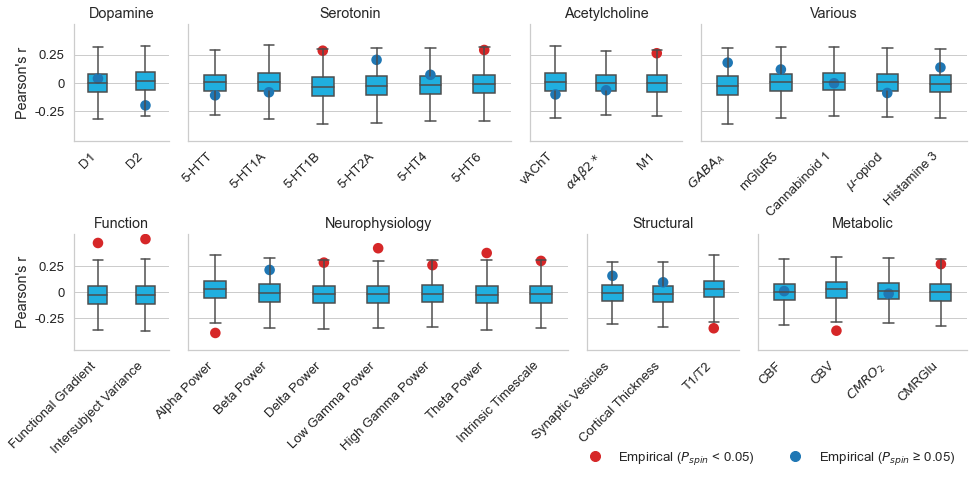

In [210]:
subgroups = {'dopamine': ( 'kaller2017_sch23390','jaworska2020_fallypride'),  
             'serotonin': ('fazio2016_madam', 'savli2012_way100635','beliveau2017_az10419369', 
                           'beliveau2017_cimbi36', 'beliveau2017_sb207145', 'radnakrishnan2018_gsk215083'), 
            'acetylcholine': ('tuominen_feobv', 'hillmer2016_flubatine', 'naganawa2020_lsn3172176'),
            'function': ('margulies2016_fcgradient01', 'mueller2013_intersubjvar'),
             'neurophysiology': ('hcps1200_megalpha','hcps1200_megbeta', 'hcps1200_megdelta', 
                            'hcps1200_meggamma1', 'hcps1200_meggamma2',
                            'hcps1200_megtheta', 'hcps1200_megtimescale'),
             'structural': ('finnema2016_ucbj', 'hcps1200_thickness', 'hcps1200_myelinmap'),
             'various': ('dukart2018_flumazenil', 'dubois2015_abp688',
                         'laurikainen2018_fmpepd2', 'kantonen2020_carfentanil',
                        'gallezot2017_gsk189254'),
             'metabolic' : ('raichle_cbf', 'raichle_cbv', 'raichle_cmr02', 'raichle_cmruglu')
            }



plot_order = ["dopamine", "serotonin", "acetylcholine", "various", "function", "neurophysiology", 
              "structural", "metabolic"]

fig = plt.figure(figsize=(16,6))
gs = fig.add_gridspec(2, 16, hspace=0.8, wspace=0.5)
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

f_ax1 = fig.add_subplot(gs[0, 0:2])
f_ax2 = fig.add_subplot(gs[0, 2:8], sharey=f_ax1)
f_ax3 = fig.add_subplot(gs[0, 8:11], sharey=f_ax1)
f_ax4 = fig.add_subplot(gs[0, 11:], sharey=f_ax1)
f_ax5 = fig.add_subplot(gs[1, 0:2])
f_ax6 = fig.add_subplot(gs[1, 2:9], sharey=f_ax5)
f_ax7 = fig.add_subplot(gs[1, 9:12], sharey=f_ax5)
f_ax7 = fig.add_subplot(gs[1, 12:], sharey=f_ax5)


sns.set(font_scale=1.2)

for i,ax in enumerate(fig.get_axes()):
    df_nulls = pd.DataFrame(np.column_stack([nulls_turku.get(key) for key in subgroups[plot_order[i]]]))
    df_nulls.columns = subgroups[plot_order[i]]
    df_corrs = pd.DataFrame([corrs_turku.get(key) for key in subgroups[plot_order[i]]])
    xlabel = [change_x_labels[key] for key in df_nulls.columns]
    #xlabel = [colname[1] for colname in [colname.split('_') for colname in df_nulls.columns]]
    df_corrs.columns = ['rho', 'pspin']
    df_corrs['tracers'] = xlabel
    color = ((df_corrs['pspin'] > 0.05).astype(int)).tolist()
    color = [(0.839, 0.152, 0.156) if x == 0 else (0.121, 0.466, 0.705) for x in color]
    x = np.arange(df_corrs.shape[0])
    cpalette = dict(zip(x, color))
    sns.set_style("whitegrid")
    #sns.despine()
    sns.boxplot(data=df_nulls, width=0.4, fliersize=0, color ='deepskyblue', ax=ax);
    pp = sns.pointplot(x=x,
                  y=df_corrs['rho'],
                  palette=cpalette,
                  join = False , 
                  scale=1.2, 
                  alpha=0.1, 
                  ax=ax );

    ax.set_title(plot_order[i].capitalize())
    if i in [0,4]:
        ax.set(yticks=[-.25, 0, .25], ylabel="Pearson's r")
        ax.set_yticklabels([ '-0.25', '0', '0.25'])
    else:
        ax.tick_params(axis='y', which='both', length=0, labelleft=False)
        ax.set_ylabel(None)
        ax.spines['left'].set_visible(True)
        
    ax.set_xticklabels(xlabel, rotation=45, ha="right")

blue_circle = mlines.Line2D([], [], color=(0.839, 0.152, 0.156), marker='o', linestyle='None',
                          markersize=10, label='Empirical ($P_{spin}$ < 0.05)')
red_circle = mlines.Line2D([], [], color=(0.121, 0.466, 0.705), marker='o', linestyle='None',
                          markersize=10, label='Empirical ($P_{spin}$ ≥ 0.05)' )
plt.legend(handles=[blue_circle, red_circle], frameon=False, bbox_to_anchor=(1, -0.75), ncol=2)

plt.savefig(path + 'figures/Figure3.jpg', bbox_inches="tight", dpi=300)    

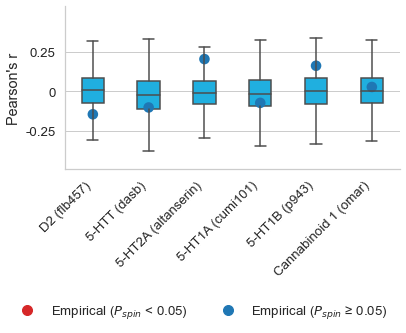

In [207]:
alternatives = ['sandiego2015_flb457','beliveau2017_dasb','savli2012_altanserin',
                'beliveau2017_cumi101', 'savli2012_p943','normandin2015_omar']


df_nulls = pd.DataFrame(np.column_stack([nulls_turku.get(key) for key in alternatives]))
df_nulls.columns = alternatives

df_corrs = pd.DataFrame([corrs_turku.get(key) for key in alternatives])
tracer_names = [colname[1] for colname in [colname.split('_') for colname in df_nulls.columns]]
target_names = ['D2', '5-HTT', '5-HT2A', '5-HT1A', '5-HT1B', 'Cannabinoid 1']
xlabel = []
for item1, item2 in zip(target_names, tracer_names):
    xlabel.append(item1 + " (" + item2 + ")")
    
df_corrs.columns = ['rho', 'pspin']
df_corrs['tracers'] = xlabel
color = ((df_corrs['pspin'] > 0.05).astype(int)).tolist()
color = [(0.839, 0.152, 0.156) if x == 0 else (0.121, 0.466, 0.705) for x in color]
x = np.arange(df_corrs.shape[0])
cpalette = dict(zip(x, color))
    
fig = plt.figure(figsize=(6,3))
sns.set_style("whitegrid")

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

g=sns.boxplot(data=df_nulls, width=0.4, fliersize=0, color ='deepskyblue')
sns.pointplot(x=x,
              y=df_corrs["rho"],
              palette=cpalette,
              join = False , 
              scale=1.2, 
              alpha=0.1, ax=g);
g.set(yticks=[-.25, 0, .25], ylabel="Pearson's r")
g.set_yticklabels(['-0.25', '0', '0.25'])
g.set_xticklabels(xlabel, rotation=45, ha="right")

blue_circle = mlines.Line2D([], [], color=(0.839, 0.152, 0.156), marker='o', linestyle='None',
                          markersize=10, label='Empirical ($P_{spin}$ < 0.05)')
red_circle = mlines.Line2D([], [], color=(0.121, 0.466, 0.705), marker='o', linestyle='None',
                          markersize=10, label='Empirical ($P_{spin}$ ≥ 0.05)' )
plt.legend(handles=[blue_circle, red_circle], frameon=False, bbox_to_anchor=(1, -0.75), ncol=2)

plt.savefig(path + 'figures/Supp_Fig2.jpg', bbox_inches="tight", dpi=300)    

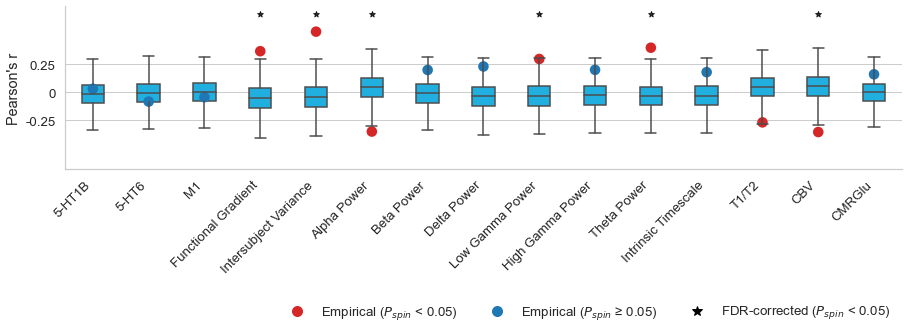

In [208]:
replicate  = ['beliveau2017_az10419369','radnakrishnan2018_gsk215083', 'naganawa2020_lsn3172176',  
              'margulies2016_fcgradient01','mueller2013_intersubjvar',  'hcps1200_megalpha','hcps1200_megbeta', 'hcps1200_megdelta', 
              'hcps1200_meggamma1', 'hcps1200_meggamma2','hcps1200_megtheta', 'hcps1200_megtimescale', 'hcps1200_myelinmap','raichle_cbv', 
              'raichle_cmruglu']

df_nulls = pd.DataFrame(np.column_stack([nulls_enigma.get(key) for key in replicate]))
df_nulls.columns = replicate

df_corrs = pd.DataFrame([corrs_enigma.get(key) for key in replicate])
xlabel = [change_x_labels[key] for key in df_nulls.columns]

df_corrs.columns = ['rho', 'pspin']
df_corrs['tracers'] = xlabel
_, fdr_corrected_pvalues, _, _ = multipletests(df_corrs['pspin'], alpha=0.05, method='fdr_bh')

# add the FDR corrected p-values as a new column to the dataframe
df_corrs['fdr_corrected_p_value'] = fdr_corrected_pvalues
color = ((df_corrs['pspin'] > 0.05).astype(int)).tolist()
color = [(0.839, 0.152, 0.156) if x == 0 else (0.121, 0.466, 0.705) for x in color]
x = np.arange(df_corrs.shape[0])
cpalette = dict(zip(x, color))
    
fig = plt.figure(figsize=(15,3))
sns.set_style("whitegrid")

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False


ax = sns.boxplot(data=df_nulls, width=0.4, fliersize=0, color ='deepskyblue')
ax = sns.pointplot(x=x,
              y=df_corrs['rho'],
              palette=cpalette,
              join = False , 
              scale=1.2, 
              alpha=0.1);
ax.set(yticks=[-.25, 0, .25], ylabel="Pearson's r")
ax.set_yticklabels(['-0.25', '0', '0.25'])
ax.set_xticklabels(xlabel, rotation=45, ha="right")

# annotate those that survive FDR correction 
xstars = np.where(df_corrs['fdr_corrected_p_value'] < 0.05)[0]
ystars = np.ones(len(xstars)) * 0.7
ax = sns.regplot(x=xstars, y=ystars, fit_reg=False, marker="*", color="black")

blue_circle = mlines.Line2D([], [], color=(0.839, 0.152, 0.156), marker='o', linestyle='None',
                          markersize=10, label='Empirical ($P_{spin}$ < 0.05)')
red_circle = mlines.Line2D([], [], color=(0.121, 0.466, 0.705), marker='o', linestyle='None',
                          markersize=10, label='Empirical ($P_{spin}$ ≥ 0.05)' )
black_star = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=10, label='FDR-corrected ($P_{spin}$ < 0.05)' )
plt.legend(handles=[blue_circle, red_circle, black_star], frameon=False, bbox_to_anchor=(1, -0.75), ncol=3)

plt.savefig(path + 'figures/Figure4.jpg', bbox_inches="tight", dpi=300) 